# **Building & Evaluating a Hybrid RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of Hybrid RAG systems(powered by Exact + Semantic Retrieval)  using a blend of open-source libraries. Our toolkit includes [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

### **1. Import relevant packages**

In [2]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from tqdm import tqdm
from getpass import getpass
from dotenv import load_dotenv
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [3]:
load_dotenv()

True

### **2. Setup your openai key**

In [4]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### **3.  Retrieve the documents / dataset to be used**

In [5]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


In [6]:
len(dataset)

491

In [8]:
dataset[150]

{'text': '---\n\ntitle: Vectors\n\nweight: 41\n\naliases:\n\n  - /vectors\n\n---\n\n\n\n\n\n# Vectors\n\n\n\nVectors (or embeddings) are the core concept of the Qdrant Vector Search engine. \n\nVectors define the similarity between objects in the vector space.\n\n\n\nIf a pair of vectors are similar in vector space, it means that the objects they represent are similar in some way.\n\n\n\nFor example, if you have a collection of images, you can represent each image as a vector.\n\nIf two images are similar, their vectors will be close to each other in the vector space.\n\n\n\nIn order to obtain a vector representation of an object, you need to apply a vectorization algorithm to the object.\n\nUsually, this algorithm is a neural network that converts the object into a fixed-size vector.\n\n\n\nThe neural network is usually [trained](/articles/metric-learning-tips/) on a pairs or [triplets](/articles/triplet-loss/) of similar and dissimilar objects, so it learns to recognize a specific ty

### **4. Process dataset as langchain document for further processing**

In [9]:
from tqdm import tqdm
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

100%|████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:00<00:00, 3372.99it/s]


491

### **5. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

## Check https://python.langchain.com/v0.2/docs/concepts/#text-splitters for supported text splitters
def split_documents(documents,chunk_size,chunk_overlap):
    docs_processed = []
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )
    for doc in documents:
        docs_processed += text_splitter.split_documents([doc])
    return docs_processed

In [11]:
CHUNK_SIZE=512
CHUNK_OVERLAP=50
processed_docs = split_documents(langchain_docs,CHUNK_SIZE,CHUNK_OVERLAP)
len(processed_docs)

9267

In [135]:
def process_document_embeddings(docs_processed):
    docs_contents = []
    docs_metadatas = []

    for doc in docs_processed:
        if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
            docs_contents.append(doc.page_content)
            docs_metadatas.append(doc.metadata)
        else:
            # Handle the case where attributes are missing
            print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")
    
    print("data-size : ",len(docs_processed))
    print("content : ",len(docs_contents))
    print("metadata : ",len(docs_metadatas))
    return (docs_contents,docs_metadatas)

### **6. Embedding Generation using Fastembed**
[FastEmbed](https://qdrant.github.io/fastembed/) is a lightweight, fast, Python library built for embedding generation.

In [199]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

,model,dim,description,size_in_GB,sources,model_file,additional_files
0,BAAI/bge-base-en,768,"Text embeddings, Unimodal (text), English, 512...",0.420,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
1,BAAI/bge-base-en-v1.5,768,"Text embeddings, Unimodal (text), English, 512...",0.210,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
2,BAAI/bge-large-en-v1.5,1024,"Text embeddings, Unimodal (text), English, 512...",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'},model.onnx,NaN
3,BAAI/bge-small-en,384,"Text embeddings, Unimodal (text), English, 512...",0.130,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
4,BAAI/bge-small-en-v1.5,384,"Text embeddings, Unimodal (text), English, 512...",0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'},model_optimized.onnx,NaN
5,BAAI/bge-small-zh-v1.5,512,"Text embeddings, Unimodal (text), Chinese, 512...",0.090,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
6,sentence-transformers/paraphrase-multilingual-...,384,"Text embeddings, Unimodal (text), Multilingual...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...,model_optimized.onnx,NaN
7,thenlper/gte-large,1024,"Text embeddings, Unimodal (text), English, 512...",1.200,{'hf': 'qdrant/gte-large-onnx'},model.onnx,NaN
8,mixedbread-ai/mxbai-embed-large-v1,1024,"Text embeddings, Unimodal (text), English, 512...",0.640,{'hf': 'mixedbread-ai/mxbai-embed-large-v1'},onnx/model.onnx,NaN
9,snowflake/snowflake-arctic-embed-xs,384,"Text embeddings, Unimodal (text), English, 512...",0.090,{'hf': 'snowflake/snowflake-arctic-embed-xs'},onnx/model.onnx,NaN


In [27]:
##Initilising embedding model
## Using Default Model - BAAI/bge-small-en-v1.5
dense_embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)
#embedding_model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", max_length=384)

dense_embedding_model.model_name

'BAAI/bge-small-en-v1.5'

In [200]:
## Declaring the intended Embedding Model with Fastembed
from fastembed import SparseTextEmbedding

pd.DataFrame(SparseTextEmbedding.list_supported_models())

,model,vocab_size,description,size_in_GB,sources,model_file,additional_files,requires_idf
0,prithivida/Splade_PP_en_v1,30522.0,Independent Implementation of SPLADE++ Model f...,0.532,{'hf': 'Qdrant/SPLADE_PP_en_v1'},model.onnx,NaN,NaN
1,prithvida/Splade_PP_en_v1,30522.0,Independent Implementation of SPLADE++ Model f...,0.532,{'hf': 'Qdrant/SPLADE_PP_en_v1'},model.onnx,NaN,NaN
2,Qdrant/bm42-all-minilm-l6-v2-attentions,30522.0,"Light sparse embedding model, which assigns an...",0.090,{'hf': 'Qdrant/all_miniLM_L6_v2_with_attentions'},model.onnx,[stopwords.txt],True
3,Qdrant/bm25,NaN,BM25 as sparse embeddings meant to be used wit...,0.010,{'hf': 'Qdrant/bm25'},mock.file,"[arabic.txt, azerbaijani.txt, basque.txt, beng...",True


In [201]:
from fastembed.sparse.bm25 import Bm25

# This triggers the model download
bm25_embedding_model = Bm25("Qdrant/bm25")

splade_embedding_model = SparseTextEmbedding(model_name="prithivida/Splade_PP_en_v1", batch_size=32)

Fetching 5 files: 100%|█████████████████████████████████████████████████████████████| 5/5 [36:21<00:00, 436.24s/it]


In [41]:
## Declaring the intended Embedding Model with Fastembed
from fastembed import LateInteractionTextEmbedding

pd.DataFrame(LateInteractionTextEmbedding.list_supported_models())

,model,dim,description,size_in_GB,sources,model_file
0,colbert-ir/colbertv2.0,128,Late interaction model,0.44,{'hf': 'colbert-ir/colbertv2.0'},model.onnx
1,answerdotai/answerai-colbert-small-v1,96,"Text embeddings, Unimodal (text), Multilingual...",0.13,{'hf': 'answerdotai/answerai-colbert-small-v1'},vespa_colbert.onnx


In [42]:
from fastembed.late_interaction import LateInteractionTextEmbedding

late_interaction_embedding_model = LateInteractionTextEmbedding("answerdotai/answerai-colbert-small-v1")

Fetching 5 files: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39346.19it/s]


### **7. Setting up our vector store - Qdrant**

Set up the qdrant client and then create a collection so that our document embeddings can be stored.

In [136]:

##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [153]:
## Collection name that will be used throughtout in the notebook
## Collection name for the hybrid search with dense & sparse(BM25)
COLLECTION_NAME = "qdrant-docs-rag-hybrid"
## Collection name for the hybrid search with dense & sparse(splade)
COLLECTION_NAME_SPLADE = "qdrant-docs-rag-hybrid-splade"
## Collection name for the hybrid search with dense , sparse and late interaction
COLLECTION_NAME_COLBERT = "qdrant-docs-rag-hybrid-colbert"

In [138]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='wine_mag_selfquery'), CollectionDescription(name='posts'), CollectionDescription(name='users'), CollectionDescription(name='qdrant-docs-rag-hybrid-colbert'), CollectionDescription(name='users_with_sparse'), CollectionDescription(name='qdrant-docs-rag-langchain')])

In [143]:
from qdrant_client import QdrantClient, models

print("dense embedding model : " , dense_embedding_model.model_name)
print("sparse embedding model : ", bm25_embedding_model.model_name)
client.set_model(dense_embedding_model.model_name)
client.set_sparse_model(bm25_embedding_model.model_name)

## Adding dense and bm25 sparse vector points to the collection
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

dense embedding model :  BAAI/bge-small-en-v1.5
sparse embedding model :  Qdrant/bm25


Fetching 29 files: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 13222.61it/s]


['fb16de2aa25d4f99a9e05d78ec4e3080',
 '9faf493b4935423486ac155cd4227aee',
 '6d798b0788a54bc8b37f21bd10acd0a1',
 '13092efaf41b43f1b1396d87f4539574',
 'a24b298c500048a5b5e3c2dc0453287f',
 '211021b4d4774a7d9c1dfcd8c7a7265a',
 '646674ab0bad41e2a462f87580625766',
 '16070d05d4f94f06b3f0715bb61e97b7',
 '7f7f10c23fb440ab9c8fbf32c0b0d831',
 '27a8a1dbc1b74d4abc62524a924fee28',
 '605fee51388b45bb894fdc7d4c085e53',
 '39862f04f137437da4960100ca379114',
 'dad2945e464747149a63fbeb4e9bd3d4',
 'bd56bc4ad68d4aed81b8667f0fd57560',
 'bbce157e446a4e259a5967529c8c69fa',
 'b17cb19fb137418fa8e84980d2b21f24',
 'a7cc4579fb2c49c0984f598cb604d862',
 '9008fcebe9514fb4b95266f03197fe68',
 'ce076867507b459186f036bd97fa1388',
 'a3e3c068777b4eafb44f42bce2474456',
 '22f98cb96a76457da089e26c6c733570',
 'd921db884aa74278bd9f4bcac331f866',
 'a2d84fc474b54a3b9d72f36bd96d1704',
 '0df205208321425cb1f1c8d3f275dbe3',
 'b9ff858fd21c4f35977c942df149ff4a',
 'ce1c986384664a12bbccb3f783e09ea0',
 'bd8d46317fb0434a8db64614d6fe674b',
 

In [202]:
from qdrant_client import QdrantClient, models

print("dense embedding model : " , dense_embedding_model.model_name)
print("sparse embedding model : ", splade_embedding_model.model_name)
client.set_model(dense_embedding_model.model_name)
client.set_sparse_model(splade_embedding_model.model_name)

## Adding dense and splade sparse vector points to the collection
client.add(collection_name=COLLECTION_NAME_SPLADE, metadata=docs_metadatas, documents=docs_contents)

dense embedding model :  BAAI/bge-small-en-v1.5
sparse embedding model :  prithivida/Splade_PP_en_v1


Fetching 5 files: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16294.89it/s]


['2c0ba299c2a445398281562169e5c3f9',
 'd19dd0bfbf874dd5ab85199bc5bdd115',
 'a1662de818be405a800b3aeb07c7d4ed',
 '4253447d258c4b5b85f93b82a45cb03e',
 '1cde7a2879e646faa078ebcd165325ca',
 'bbf215a5cd424f638a9830d9977d2250',
 '018682068432480bb635a46e7f471c94',
 'f59c7f293d1f45068102dd4fa3f8d2f4',
 '465b893a01fd4353a97fadabe956dd1f',
 '3998982ae2414924a279ecf91c3f422a',
 'daf66db996b04ce7909093d45c7cac56',
 'bd23fa48949f43988785dc62c26df93b',
 '5129f7500ff24ed49e3115a7d38e0325',
 '9059a0acaa99433d8bec5f375bcb2a13',
 '6a4ad3a0923f4e70a7c1f58687ab1031',
 'a8c9b998742f4c35bfc23deac62c9f27',
 '942a6cc64ee244fa9e54b99196763450',
 'f0c60a390ffc454782ddea3190d3dda0',
 'b4efb00330de484dbf831180ac0d3e9f',
 '4b833c0ed6e942e38b57ae21a1f231e4',
 '50ce4048bc8c47b38ed24510b4b8a540',
 '1b0733b00d82425da5d0b3efd2ed0569',
 '28fc8634a025416dbf0c88d063477cfe',
 '344a0f71335c432f94057cd11ac1850b',
 '37a2b4fcdee249a7acf0086a086e8630',
 'f1d02be8f78b489499f9b61dc87cb8a2',
 '6e4364b3eddd420caff658d993d094a0',
 

In [60]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=9267)

### **8. Searching for the document**

In [390]:
def pretty_print_results(results):
    for point in results.points:
        score = point.score
        document = point.payload['document']
        source = point.payload['source']
        print(f"Score: {score}\nDocument: {document}\n\nSource: {source}\n")

In [391]:
question="what is binary quantization"

In [392]:
COLLECTION_NAME_SINGLE_VECTOR = "qdrant-docs-rag-langchain"

In [393]:
def query_dense(question,k):
    results_dense = client.query_points(
        COLLECTION_NAME,
        query=next(dense_embedding_model.query_embed(question)),
        using="fast-bge-small-en-v1.5",
        limit=k,
        with_payload=True,
    )
    return results_dense

In [394]:
pretty_print_results(query_dense(question,3))

Score: 0.90222883
Document: [Binary Quantization](/articles/binary-quantization/) is a fast indexing and data compression method used by Qdrant. It supports vector comparisons, which can dramatically speed up query processing times (up to 40x faster!).

Source: articles/what-is-a-vector-database.md

Score: 0.8656155
Document: Please refer to the [Quantization Tips](#quantization-tips) section for more information on how to optimize the quantization parameters for your use case.



## Binary Quantization



*Available as of v1.5.0*



Binary quantization is an extreme case of scalar quantization.

This feature lets you represent each vector component as a single bit, effectively reducing the memory footprint by a **factor of 32**.

Source: documentation/guides/quantization.md

Score: 0.86145616
Document: Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced performance and efficiency with binary quantizati

In [205]:
## Generating BM25 vector for the given query
def make_bm25_embedding(query):
    query_vector_indices, query_vector_values = [], []
    for embedding in bm25_embedding_model.embed(query):
        query_vector_indices.append(embedding.indices.tolist())
        query_vector_values.append(embedding.values.tolist())
    return (query_vector_indices,query_vector_values)

## Generating Splade vector for the given query
def make_splade_embedding(query):
    indices, values = [], []
    for embedding in splade_embedding_model.embed(query):
        indices.append(embedding.indices.tolist())
        values.append(embedding.values.tolist())
    return indices, values

In [203]:
client.scroll(COLLECTION_NAME, limit=1, with_vectors=True)[0][0].vector['fast-sparse-bm25']

SparseVector(indices=[65094886, 90097469, 171321964, 294778681, 301705055, 308817224, 411938730, 559619788, 674488209, 754797265, 812157138, 874403274, 976245805, 1037980684, 1116117978, 1172383616, 1190790875, 1198767231, 1236542976, 1267882734, 1336553514, 1404934148, 1430088939, 1431075457, 1439987386, 1455480578, 1491351846, 1535722001, 1563718956, 1607792561, 1638876560, 1750525656, 1755673004, 1763574823, 1771524004, 1872054170, 1937911219, 1955044337, 1983788264, 2017312581, 2058513491, 2072640357], values=[1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.7950598, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161, 1.5160161])

In [361]:
## BM25 Query example
def query_bm25(question,k):
    bm25_query_vector_indices,bm25_query_vector_values = make_bm25_embedding(question)
    
    results_bm25 = client.query_points(
        COLLECTION_NAME,
        query=models.SparseVector(
            indices=bm25_query_vector_indices[0],  # Indices of non-zero elements
            values=bm25_query_vector_values[0]  # Corresponding non-zero values
        ),
        using="fast-sparse-bm25",
        with_payload=True,
        limit=k,
    )
    return results_bm25

pretty_print_results(query_bm25(question,3))


Score: 26.786758
Document: Our implementation of quantization achieves a good balance between full, large vectors at ranking time and binary vectors at search and retrieval time. It also has the ability for you to adjust this balance depending on your use case.



## Faster search and retrieval



Unlike product quantization, binary quantization does not rely on reducing the search space for each probe. Instead, we build a binary index that helps us achieve large increases in search speed.

Score: 26.614773
Document: Right, so our choice of quantization is mostly defined by available CPU instructions we can apply to perform those computations. In case of binary quantization, it's straightforward and very simple. That's why we like binary quantization so much. In case of, for example, four bit quantization, it is not as clear which operation we should use. It's not yet clear

Score: 26.524483
Document: This is the fastest quantization method, since it lets you perform a vector compariso

In [360]:
## Hybrid Query - Dense + BM25
def query_hybrid_bm25(question,k):
    bm25_query_vector_indices,bm25_query_vector_values = make_bm25_embedding(question)
    
    results_hybrid_bm25 = client.query_points(
        collection_name=COLLECTION_NAME,
        prefetch=[
            models.Prefetch(
                query=models.SparseVector(
                    indices=bm25_query_vector_indices[0], 
                    values=bm25_query_vector_values[0]
                 ),
                 using="fast-sparse-bm25",
                 limit=k,
            ),
            models.Prefetch(
                query=next(dense_embedding_model.query_embed(question)),
                using="fast-bge-small-en-v1.5",
                limit=k,
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
    )
    return results_hybrid_bm25

pretty_print_results(query_hybrid_bm25(question,3))

Score: 0.5
Document: Our implementation of quantization achieves a good balance between full, large vectors at ranking time and binary vectors at search and retrieval time. It also has the ability for you to adjust this balance depending on your use case.



## Faster search and retrieval



Unlike product quantization, binary quantization does not rely on reducing the search space for each probe. Instead, we build a binary index that helps us achieve large increases in search speed.

Score: 0.5
Document: [Binary Quantization](/articles/binary-quantization/) is a fast indexing and data compression method used by Qdrant. It supports vector comparisons, which can dramatically speed up query processing times (up to 40x faster!).

Score: 0.33333334
Document: Please refer to the [Quantization Tips](#quantization-tips) section for more information on how to optimize the quantization parameters for your use case.



## Binary Quantization



*Available as of v1.5.0*



Binary quantization is 

In [364]:
## Splade Query Example
def query_splade(question,k):
    splade_query_vector_indices,splade_query_vector_values = make_splade_embedding(question)
    
    results_splade = client.query_points(
        COLLECTION_NAME_SPLADE,
        query=models.SparseVector(
            indices=splade_query_vector_indices[0],  # Indices of non-zero elements
            values=splade_query_vector_values[0]  # Corresponding non-zero values
        ),
        using="fast-sparse-splade_pp_en_v1",
        with_payload=True,
        limit=k,
    )
    return results_splade

pretty_print_results(query_splade(question,3))

Score: 24.51442
Document: [Binary Quantization](/articles/binary-quantization/) is a fast indexing and data compression method used by Qdrant. It supports vector comparisons, which can dramatically speed up query processing times (up to 40x faster!).

Score: 22.36588
Document: ## What is Binary Quantization?

Binary quantization (BQ) converts any vector embedding of floating point numbers into a vector of binary or boolean values. This feature is an extension of our past work on [scalar quantization](/articles/scalar-quantization/) where we convert `float32` to `uint8` and then leverage a specific SIMD CPU instruction to perform fast vector comparison. 



![What is binary quantization](/articles_data/binary-quantization/bq-2.png)

Score: 22.04826
Document: ---

title: "Binary Quantization - Vector Search, 40x Faster "

short_description: "Binary Quantization is a newly introduced mechanism of reducing the memory footprint and increasing performance"

description: "Binary Quantization 

In [357]:
## Hybrid Query - Dense + Splade
def query_hybrid_splade(question,k):
    splade_query_vector_indices,splade_query_vector_values = make_splade_embedding(question)
    
    results_hybrid_splade = client.query_points(
        collection_name=COLLECTION_NAME_SPLADE,
        prefetch=[
            models.Prefetch(
                query=models.SparseVector(
                    indices=splade_query_vector_indices[0], 
                    values=splade_query_vector_values[0]
                 ),
                 using="fast-sparse-splade_pp_en_v1",
                 limit=k,
            ),
            models.Prefetch(
                query=next(dense_embedding_model.query_embed(question)),
                using="fast-bge-small-en-v1.5",
                limit=k,
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
    )
    return results_hybrid_splade

pretty_print_results(query_hybrid_splade(question,3))

Score: 1.0
Document: [Binary Quantization](/articles/binary-quantization/) is a fast indexing and data compression method used by Qdrant. It supports vector comparisons, which can dramatically speed up query processing times (up to 40x faster!).

Score: 0.33333334
Document: ## What is Binary Quantization?

Binary quantization (BQ) converts any vector embedding of floating point numbers into a vector of binary or boolean values. This feature is an extension of our past work on [scalar quantization](/articles/scalar-quantization/) where we convert `float32` to `uint8` and then leverage a specific SIMD CPU instruction to perform fast vector comparison. 



![What is binary quantization](/articles_data/binary-quantization/bq-2.png)

Score: 0.33333334
Document: Please refer to the [Quantization Tips](#quantization-tips) section for more information on how to optimize the quantization parameters for your use case.



## Binary Quantization



*Available as of v1.5.0*



Binary quantization i

### **9. Experimenting with Colbert / Multivector in Qdrant**

In [279]:
client.delete_collection(COLLECTION_NAME_COLBERT)

True

In [280]:
from qdrant_client import QdrantClient, models

client.create_collection(
    COLLECTION_NAME_COLBERT,
    vectors_config={
        "fast-bge-small-en": models.VectorParams(
            size=384,
            distance=models.Distance.COSINE,
        ),
        "answerai-colbert-small-v1": models.VectorParams(
            size=96,
            distance=models.Distance.COSINE,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            )
        ),
    },
    sparse_vectors_config={
        "bm25": models.SparseVectorParams(
            modifier=models.Modifier.IDF,
        )
    }
)


True

In [281]:
from qdrant_client import QdrantClient, models

print("dense embedding model : " , dense_embedding_model.model_name)
print("sparse embedding model : ", bm25_embedding_model.model_name)

client.set_model(dense_embedding_model.model_name)
client.set_sparse_model(bm25_embedding_model.model_name)


dense embedding model :  BAAI/bge-small-en-v1.5
sparse embedding model :  Qdrant/bm25


In [282]:
def make_colbert_embedding(query):
    return list(late_interaction_embedding_model.embed(query))

In [283]:
print (make_colbert_embedding(question))

[array([[-7.69344568e-02,  5.32535240e-02, -4.51293550e-02,
         5.70768444e-03, -8.33698213e-02, -5.45133790e-03,
        -2.82295533e-02, -1.52826682e-01, -1.49168536e-01,
        -2.65449416e-02,  1.31750718e-01, -1.32822990e-01,
         4.15555537e-02, -5.65585727e-03, -4.35529128e-02,
        -1.05052166e-01,  2.06573978e-02, -1.35419577e-01,
        -6.28748611e-02, -1.56928316e-01,  1.01727903e-01,
         4.61191265e-03, -1.51878878e-01,  1.62229940e-01,
        -6.91899359e-02,  9.46592167e-02,  3.48524743e-04,
        -1.15066268e-01, -2.22331986e-01,  1.22745685e-01,
         2.71318220e-02,  1.10036165e-01, -1.25884801e-01,
        -2.82850284e-02,  5.00412434e-02,  1.90421138e-02,
        -2.75818259e-02,  9.34606493e-02, -8.79437402e-02,
        -9.36552957e-02,  5.78454472e-02, -4.18046638e-02,
         2.88366210e-02,  8.25763196e-02, -7.87995011e-02,
         5.83556406e-02,  1.13453545e-01,  1.03123479e-01,
         3.69259529e-02, -1.63658112e-02,  5.52734509e-

In [ ]:
## Indexing documents with 3 named vectors for dense , sparse and colbert
for doc, metadata in zip(docs_contents, docs_metadatas):  # Iterate over both lists
        dense_embedding = list(dense_embedding_model.passage_embed(doc))
        bm25_embedding = list(bm25_embedding_model.passage_embed(doc))
        late_interaction_embedding = list(late_interaction_embedding_model.passage_embed(doc))

        # Combine docs_metadatas and docs_contents
        combined_payload = metadata.copy()  # Copy metadata to avoid modifying the original
        combined_payload['document'] = doc  # Add document content to payload
        
        client.upsert(
            collection_name = COLLECTION_NAME_COLBERT,
            points=[
                models.PointStruct(
                    id=str(uuid.uuid4()),  # Generate a unique ID
                    payload=combined_payload,  # Use the combined payload
                    vector={
                        "fast-bge-small-en": dense_embedding[0].tolist(),
                        "bm25": models.SparseVector(
                                indices=bm25_embedding[0].indices.tolist(), values=bm25_embedding[0].values.tolist()
                        ),
                        "answerai-colbert-small-v1": late_interaction_embedding[0].tolist(),
                    },
                )
            ],
        )


In [348]:
client.count(COLLECTION_NAME_COLBERT)

CountResult(count=8999)

In [287]:
client.scroll(COLLECTION_NAME_COLBERT, limit=1, with_vectors=True)[0][0].vector['answerai-colbert-small-v1']

[[-0.07335234,
  0.0415884,
  -0.04593376,
  -0.00078451727,
  -0.07987661,
  -0.0014808093,
  -0.02479791,
  -0.15227862,
  -0.1648463,
  -0.019539036,
  0.12066865,
  -0.1292244,
  0.04779733,
  -0.011033952,
  -0.04228724,
  -0.10433247,
  0.018119466,
  -0.1414409,
  -0.06885185,
  -0.16082764,
  0.1108214,
  -0.00051499833,
  -0.15857574,
  0.1670268,
  -0.065214664,
  0.08131836,
  -0.0010997329,
  -0.1279614,
  -0.21780199,
  0.12600406,
  0.022417089,
  0.11387543,
  -0.12574062,
  -0.01846063,
  0.04136951,
  0.021329656,
  -0.0390202,
  0.0857925,
  -0.08724176,
  -0.086406544,
  0.06485404,
  -0.04483428,
  0.021664362,
  0.08156744,
  -0.08559357,
  0.06981353,
  0.11021744,
  0.10099188,
  0.03796502,
  -0.020115081,
  0.0636625,
  0.20015083,
  -0.06817606,
  0.011254974,
  -0.08026034,
  0.03576814,
  -0.04023999,
  -0.1261902,
  0.14329277,
  -0.046094984,
  -0.00010614667,
  0.14961448,
  0.058433898,
  -0.06599588,
  0.036468107,
  -0.19535404,
  0.27651337,
  -0.2034

In [286]:
results_late_interaction = client.query_points(
    COLLECTION_NAME_COLBERT,
    prefetch=models.Prefetch(
        query=next(dense_embedding_model.query_embed(question)),
        using="fast-bge-small-en",
        limit=5
    ),
    query=make_colbert_embedding(question)[0],
    using="answerai-colbert-small-v1",
    with_payload=True,
    limit=2,
)

pretty_print_results(results_late_interaction)


Score: 8.835113
Document: [Binary Quantization](/articles/binary-quantization/) is a fast indexing and data compression method used by Qdrant. It supports vector comparisons, which can dramatically speed up query processing times (up to 40x faster!).

Score: 8.807164
Document: Please refer to the [Quantization Tips](#quantization-tips) section for more information on how to optimize the quantization parameters for your use case.



## Binary Quantization



*Available as of v1.5.0*



Binary quantization is an extreme case of scalar quantization.

This feature lets you represent each vector component as a single bit, effectively reducing the memory footprint by a **factor of 32**.



In [358]:
## Hybrid Query - BM25 + Dense + Colbert
def query_hybrid_bm25_colbert(question,k):
    bm25_query_vector_indices,bm25_query_vector_values = make_bm25_embedding(question)
    
    results_hybrid_colbert = client.query_points(
        collection_name=COLLECTION_NAME_COLBERT,
        prefetch=[
            models.Prefetch(
                query=models.SparseVector(
                    indices=bm25_query_vector_indices[0], 
                    values=bm25_query_vector_values[0]
                 ),
                 using="bm25",
                 limit=k,
            ),
            models.Prefetch(
                query=next(dense_embedding_model.query_embed(question)),
                using="fast-bge-small-en",
                limit=k,
            ),
            models.Prefetch(
                query=make_colbert_embedding(question)[0],
                using="answerai-colbert-small-v1",
                limit=k,
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
    )
    return results_hybrid_colbert

In [359]:
pretty_print_results(query_hybrid_bm25_colbert(question,3))

Score: 1.0
Document: [Binary Quantization](/articles/binary-quantization/) is a fast indexing and data compression method used by Qdrant. It supports vector comparisons, which can dramatically speed up query processing times (up to 40x faster!).

Score: 0.5833334
Document: Please refer to the [Quantization Tips](#quantization-tips) section for more information on how to optimize the quantization parameters for your use case.



## Binary Quantization



*Available as of v1.5.0*



Binary quantization is an extreme case of scalar quantization.

This feature lets you represent each vector component as a single bit, effectively reducing the memory footprint by a **factor of 32**.

Score: 0.5
Document: Our implementation of quantization achieves a good balance between full, large vectors at ranking time and binary vectors at search and retrieval time. It also has the ability for you to adjust this balance depending on your use case.



## Faster search and retrieval



Unlike product quant

### **10. Building RAG with different versions of retrieval**

We now have several different ways of retrieving relevant documents, let's recollect : 

- `query_dense` - method to query through **dense** embeddings
- `query_bm25` - method to query through **bm25** embeddings
- `query_splade` - method to query through **splade** embeddings
- `query_hybrid_bm25` - method to query through **dense and bm25** embeddings
- `query_hybrid_splade` - method to query through **dense and splade(RRF)**  embeddings
- `query_hybrid_bm25_colbert` - method to query through **bm25 , dense and colbert(RRF)** embeddings 

In [450]:
def query_with_type(query_version , query , limit):
    try:
        # Use getattr to retrieve the function by name
        query_type = globals()[query_version]
        return query_type(query, limit)  # Call the query version with the given parameters
    except KeyError:
        return f"Method {query_version} not found."

In [462]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

def query_with_context(query_version , query , limit):
    
    search_result = query_with_type(query_version,query,limit) 
    
    contexts = [        
        "document:"+r.payload['document']+",source:"+r.payload['source'] for r in search_result.points    
    ]
    
    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".
        
        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (contexts , res.choices[0].text)

In [452]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truths'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, query_version , eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []
    
    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        q = entry['question']
        questions.append(q)
        context , rag_response = query_with_context(query_version,q,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)
        ground_truth = entry['answer'] 
        ground_truths.append(ground_truth)
    
    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    
    return rag_response_data

In [453]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_utilization,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

In [454]:
## Method to encapsulate ragas evaluate method with all the 8 metrics
def evaluate_with_ragas(rag_response_dataset_df):
    result = evaluate(
        rag_response_dataset_df,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_utilization,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )
    return result

In [401]:
## Define the test dataset to evaluate your rag pipeline to see the differences between each retrieval techniques
qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

RETRIEVAL_METHODS = ["query_dense" , "query_bm25" , "query_splade" , 
                     "query_hybrid_bm25" , "query_hybrid_splade" , "query_hybrid_bm25_colbert"]

EVAL_SIZE = 10

RETRIEVAL_SIZE_3 = 3


In [402]:
## Loop through different methods to evaluate
#for retrieval_method in RETRIEVAL_METHODS:
#    rag_response_data = create_eval_dataset(qdrant_qna_dataset,retrieval_method,EVAL_SIZE,RETRIEVAL_SIZE_3)
#    rag_response_dataset = Dataset.from_dict(rag_response_data)
#    rag_response_dataset.to_csv(f'rag_response_{retrieval_method}.csv')

In [463]:
RETRIEVAL_METHOD_HYBRID_BM25 = "query_hybrid_bm25"
rag_response_data_hybrid_bm25 = create_eval_dataset(qdrant_qna_dataset,RETRIEVAL_METHOD_HYBRID_BM25,EVAL_SIZE,RETRIEVAL_SIZE_3)
rag_response_dataset = Dataset.from_dict(rag_response_data_hybrid_bm25)
rag_response_dataset.to_csv(f'rag_response_{RETRIEVAL_METHOD_HYBRID_BM25}.csv')

Creating CSV from Arrow format: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 119.03ba/s]


38962

In [464]:
from ragas import evaluate
result_HYBRID_BM25 = evaluate(
        rag_response_dataset,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_utilization,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.84it/s]


In [465]:
evaluation_result_df_HYBRID_BM25 = result_HYBRID_BM25.to_pandas()
evaluation_result_df_HYBRID_BM25.iloc[:10]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_utilization,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,[document:## **Top takeaways:**\n\n\n\nDiscove...,The vacuum optimizer is a feature in Qdrant t...,The Vacuum Optimizer is a feature in the Qdran...,0.600000,0.903086,1.000000,0.166667,0.333333,0.000000,0.934762,0.511468
1,Tell me about ‘always_ram’ parameter?,[document:Suppose you have a ‘users’ collectio...,The 'always_ram' parameter is used in the qua...,In the context of vector quantization in Qdran...,1.000000,0.890101,1.000000,0.533333,0.533333,0.285714,0.957288,0.539322
2,What is difference between scalar and product ...,[document:But there are some tradeoffs. Produc...,Scalar quantization and product quantization ...,While both methods aim to reduce the memory fo...,0.666667,0.988127,1.000000,0.916667,1.000000,0.125000,0.927291,0.504550
3,What is ‘best_score’ strategy?,[document:This is the default strategy that's ...,The ‘best_score’ strategy is a new recommenda...,The `best_score` strategy is based on the idea...,1.000000,0.934751,1.000000,0.755556,0.755556,0.000000,0.916253,0.465905
4,How does oversampling helps?,[document:### Oversampling for quantization\n\...,Oversampling is a technique used to improve t...,Defines how many extra vectors should be pre-s...,1.000000,0.903528,0.666667,1.000000,1.000000,0.166667,0.888031,0.757722
5,What is the purpose of ‘CreatePayloadIndexAsync’?,[document:Suppose you have a ‘users’ collectio...,The 'CreatePayloadIndexAsync' function is use...,CreatePayloadIndexAsync is a method in the Qdr...,0.727273,0.982968,0.666667,0.555556,0.555556,0.000000,0.877187,0.377192
6,What is the purpose of ef_construct in HNSW ?,[document:# in this case full-scan search shou...,The `ef_construct` parameter in HNSW is used ...,In HNSW algorithm the ef_construct parameter i...,0.800000,0.966585,1.000000,0.679167,1.000000,0.333333,0.923716,0.793429
7,How do you use ‘ordering’ parameter?,"[document:```http\n\n""order_by"": {\n\n ""key...","To use the 'ordering' parameter, you can incl...",Write ordering can be specified for any write ...,0.666667,0.915221,0.500000,0.722222,0.722222,0.100000,0.786507,0.646627
8,What is significance of ‘on_disk_payload’ sett...,[document:* `on_disk_payload` - defines where ...,The 'on_disk_payload' setting allows for the ...,The `on_disk_payload` setting in the storage c...,0.400000,0.952338,0.500000,0.755556,0.700000,0.333333,0.900570,0.666319
9,What is the impact of ‘write_consistency_facto...,[document:Suppose you have a ‘users’ collectio...,The `write_consistency_factor` determines the...,The `write_consistency_factor` parameter in a ...,0.857143,0.916370,1.000000,0.555556,0.555556,0.500000,0.931878,0.642060


In [466]:
RETRIEVAL_METHOD_HYBRID_SPLADE = "query_hybrid_splade"
rag_response_data_hybrid_splade = create_eval_dataset(qdrant_qna_dataset,RETRIEVAL_METHOD_HYBRID_SPLADE,EVAL_SIZE,RETRIEVAL_SIZE_3)
rag_response_dataset_splade = Dataset.from_dict(rag_response_data_hybrid_splade)
rag_response_dataset_splade.to_csv(f'rag_response_{RETRIEVAL_METHOD_HYBRID_SPLADE}.csv')

Creating CSV from Arrow format: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 131.70ba/s]


37296

In [467]:
from ragas import evaluate
result_HYBRID_SPLADE = evaluate(
        rag_response_dataset_splade,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_utilization,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 80/80 [03:04<00:00,  2.30s/it]


In [468]:
evaluation_result_df_HYBRID_SPLADE = result_HYBRID_SPLADE.to_pandas()
evaluation_result_df_HYBRID_SPLADE.iloc[:10]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_utilization,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,[document:the [optimizer](../../concepts/optim...,The vacuum optimizer is a feature in the Quat...,The Vacuum Optimizer is a feature in the Qdran...,0.428571,0.893085,0.166667,0.166667,1.0000,0.000000,0.873455,0.593364
1,Tell me about ‘always_ram’ parameter?,[document:`always_ram` - whether to keep quant...,The 'always_ram' parameter is a configuration...,In the context of vector quantization in Qdran...,1.000000,0.901379,1.000000,1.000000,1.0000,0.428571,0.959969,0.921810
2,What is difference between scalar and product ...,[document:## Product Quantization vs Scalar Qu...,Scalar quantization and product quantization ...,While both methods aim to reduce the memory fo...,0.875000,0.988127,1.000000,1.000000,1.0000,0.125000,0.950886,0.821055
3,What is ‘best_score’ strategy?,[document:This is the default strategy that's ...,The 'best_score' strategy is a new recommenda...,The `best_score` strategy is based on the idea...,1.000000,0.934731,1.000000,1.000000,0.8875,0.000000,0.927305,0.446112
4,How does oversampling helps?,[document:### Oversampling for quantization\n\...,Oversampling is a technique used to improve t...,Defines how many extra vectors should be pre-s...,1.000000,0.889568,0.666667,0.804167,1.0000,0.166667,0.856521,0.390601
5,What is the purpose of ‘CreatePayloadIndexAsync’?,[document:await client.CreatePayloadIndexAsync...,The 'CreatePayloadIndexAsync' function is use...,CreatePayloadIndexAsync is a method in the Qdr...,0.500000,0.931643,0.333333,1.000000,1.0000,0.000000,0.934034,0.447794
6,What is the purpose of ef_construct in HNSW ?,"[document:The larger the value of it, the high...",The `ef_construct` parameter in HNSW is used ...,In HNSW algorithm the ef_construct parameter i...,1.000000,0.966585,0.666667,1.000000,1.0000,0.000000,0.944992,0.569468
7,How do you use ‘ordering’ parameter?,"[document:}\n\n```\n\n\n\n<aside role=""alert"">...","To use the 'ordering' parameter, you can incl...",Write ordering can be specified for any write ...,0.777778,0.915123,0.333333,0.566667,0.7100,NaN,0.846200,0.661550
8,What is significance of ‘on_disk_payload’ sett...,[document:* `on_disk_payload` - defines where ...,The 'on_disk_payload' setting is used to defi...,The `on_disk_payload` setting in the storage c...,1.000000,0.962746,0.500000,1.000000,1.0000,0.200000,0.931261,0.706499
9,What is the impact of ‘write_consistency_facto...,[document:- `write_consistency_factor` - defin...,The 'write_consistency_factor' determines the...,The `write_consistency_factor` parameter in a ...,1.000000,0.915332,1.000000,1.000000,1.0000,0.166667,0.941962,0.835491


In [469]:
RETRIEVAL_METHOD_HYBRID_BM25_COLBERT = "query_hybrid_bm25_colbert"
rag_response_data_hybrid_bm25_colbert = create_eval_dataset(qdrant_qna_dataset,RETRIEVAL_METHOD_HYBRID_BM25_COLBERT,EVAL_SIZE,RETRIEVAL_SIZE_3)
rag_response_dataset_hybrid_bm25_colbert = Dataset.from_dict(rag_response_data_hybrid_bm25_colbert)
rag_response_dataset_hybrid_bm25_colbert.to_csv(f'rag_response_{RETRIEVAL_METHOD_HYBRID_BM25_COLBERT}.csv')

Creating CSV from Arrow format: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 129.37ba/s]


45470

In [470]:
from ragas import evaluate
result_HYBRID_BM25_COLBERT = evaluate(
        rag_response_dataset_hybrid_bm25_colbert,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_utilization,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 80/80 [03:20<00:00,  2.50s/it]


In [471]:
evaluation_result_df_HYBRID_BM25_COLBERT = result_HYBRID_BM25_COLBERT.to_pandas()
evaluation_result_df_HYBRID_BM25_COLBERT.iloc[:10]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_utilization,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,[document:return optimizer\n\n```\n\n\n\nCachi...,The vacuum optimizer is a feature in Qdrant t...,The Vacuum Optimizer is a feature in the Qdran...,0.250000,0.893542,0.166667,0.500000,0.500000,0.000000,0.919749,0.490807
1,Tell me about ‘always_ram’ parameter?,[document:Suppose you have a ‘users’ collectio...,The 'always_ram' parameter is used in the qua...,In the context of vector quantization in Qdran...,0.875000,0.888055,1.000000,0.649603,0.649603,0.428571,0.962513,0.740628
2,What is difference between scalar and product ...,[document:## Product Quantization vs Scalar Qu...,Scalar quantization and product quantization ...,While both methods aim to reduce the memory fo...,0.666667,0.988127,1.000000,0.816667,0.876667,0.125000,0.927010,0.676197
3,What is ‘best_score’ strategy?,[document:This is the default strategy that's ...,The ‘best_score’ strategy is a new recommenda...,The `best_score` strategy is based on the idea...,1.000000,0.902242,1.000000,0.722619,0.648810,0.222222,0.917661,0.479415
4,How does oversampling helps?,[document:### Oversampling for quantization\n\...,Oversampling is a technique used to improve t...,Defines how many extra vectors should be pre-s...,0.944444,0.903508,0.666667,0.887500,1.000000,0.166667,0.881130,0.508744
5,What is the purpose of ‘CreatePayloadIndexAsync’?,[document:await client.CreatePayloadIndexAsync...,The 'CreatePayloadIndexAsync' function is use...,CreatePayloadIndexAsync is a method in the Qdr...,0.500000,0.982968,0.333333,0.916667,0.916667,0.000000,0.864434,0.366108
6,What is the purpose of ef_construct in HNSW ?,"[document:In order to improve performance, HNS...",The ef_construct parameter in HNSW is used to...,In HNSW algorithm the ef_construct parameter i...,0.833333,0.980020,0.666667,0.810000,0.926667,0.333333,0.940511,0.860128
7,How do you use ‘ordering’ parameter?,"[document:- Write `ordering` param, can be use...","To use the 'ordering' parameter, you need to ...",Write ordering can be specified for any write ...,1.000000,0.920988,0.500000,0.854167,0.854167,0.090909,0.775908,0.408263
8,What is significance of ‘on_disk_payload’ sett...,[document:* `on_disk_payload` - defines where ...,The 'on_disk_payload' setting is used to defi...,The `on_disk_payload` setting in the storage c...,0.888889,0.953377,0.500000,1.000000,1.000000,0.166667,0.914378,0.603591
9,What is the impact of ‘write_consistency_facto...,[document:- `write_consistency_factor` - defin...,The `write_consistency_factor` determines the...,The `write_consistency_factor` parameter in a ...,1.000000,0.916370,1.000000,1.000000,1.000000,0.166667,0.940147,0.735037


In [472]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2 , df3):
    # Extract the specified columns from both dataframes
    headers = [ 'faithfulness',
                'answer_relevancy',
                'context_recall',
                'context_precision',
                'context_utilization',
                'context_entity_recall',
                'answer_similarity',
                'answer_correctness'
                ]
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(50, 5))
    
    # Plot bar plots for each header
    for i, header in enumerate(headers):
        ax = axes[i]
        ax.bar(['Hybrid_BM25','Hybrid_Splade', 'Hybrid_BM25_Colbert'], [df1[header].mean(), df2[header].mean(), df3[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


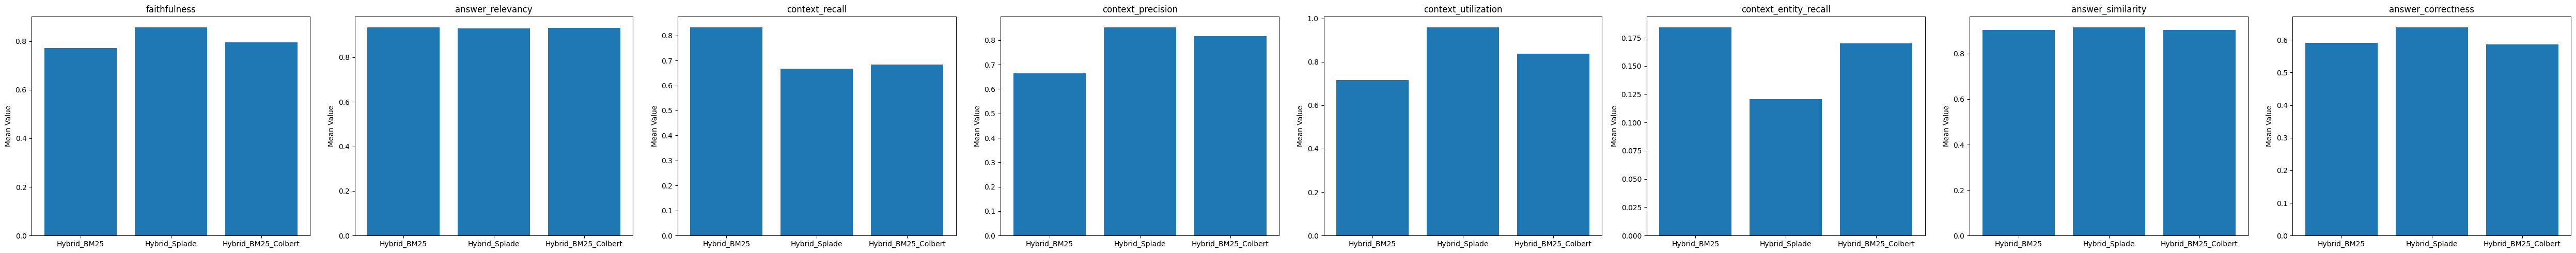

In [473]:
# Example result comparison:
compare_dataframes(evaluation_result_df_HYBRID_BM25, evaluation_result_df_HYBRID_SPLADE, evaluation_result_df_HYBRID_BM25_COLBERT)


As we can notice `recall` related metrics are certainly better with `BM25` while overall `Splade` seem to have done a better job.
We also notice that *colbert helped BM25 with precision metrics* and similar experiment can be conducted with other retrieval methods.